In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import warnings
from sklearn.model_selection import cross_val_score
from matplotlib import rcParams
from scipy import stats
from sklearn.cross_validation import train_test_split
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
rcParams['axes.titlepad'] = 20

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('automobile.csv',names=['symboling','normalized_losses','make','fuel_type','aspiration','num_of_doors','body_style','drive_wheels','engine_location','wheel_base','length','width','height','curb_weight','engine_type',
'num_of_cylinders','engine_size','fuel_system','bore','stroke','compression_ratio','horsepower','peak_rpm','city_mpg','highway_mpg','price'])

In [3]:
df.replace(to_replace='?',value=np.nan,inplace=True)
df.dropna(subset=['num_of_doors','bore', 'stroke','horsepower', 'peak_rpm','price'],inplace=True)
df['normalized_losses'].replace(to_replace=np.nan,value=0,inplace=True)
df['normalized_losses'] = df['normalized_losses'].astype(int)
df['normalized_losses'].replace(to_replace=0,value=df['normalized_losses'].mean(),inplace=True)
df['num_of_doors'] = df['num_of_doors'].map({'four':4,'two':2})
df['num_of_cylinders'] = df['num_of_cylinders'].map({'four':4,'six':6,'five':5,'eight':8,'three':3,'twelve':12})
df['bore'] = df['bore'].astype(float)
df['stroke'] = df['stroke'].astype(float)
df['horsepower'] = df['horsepower'].astype(float)
df['peak_rpm'] = df['peak_rpm'].astype(float)
df['price'] = df['price'].astype(float)
df['area'] = df['length'] * df['width'] * df['height']
df['symboling'] = df['symboling'].astype(str)
df.replace(regex=r'-',value='_',inplace=True)
li = df.select_dtypes(include=['int64','float64']).columns
for i in li :
    df[i] = np.log1p(df[i])

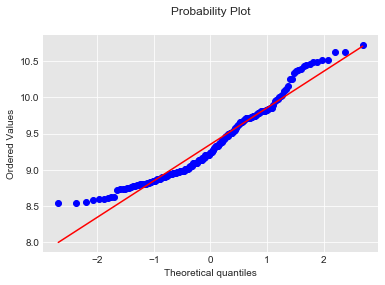

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
stats.probplot(df['price'],plot=ax)
plt.show()

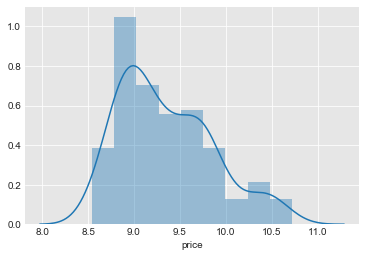

In [5]:
sns.distplot(df['price'])

In [6]:
df_dummies = pd.get_dummies(df,columns=['symboling','make','fuel_type','aspiration','body_style','drive_wheels','engine_location','engine_type','fuel_system'],drop_first=True)

In [7]:
df_dummies['Car_price'] = df_dummies['price']
df_dummies.drop(['length','width','height','price'],axis=1,inplace=True)

In [8]:
X = df_dummies.iloc[:,:-1]
y = df_dummies.iloc[:,-1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100,test_size=0.2)

In [10]:
model = sm.OLS(y_train,sm.add_constant(X_train))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Car_price   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     76.44
Date:                Mon, 12 Nov 2018   Prob (F-statistic):           3.09e-61
Time:                        01:18:46   Log-Likelihood:                 176.49
No. Observations:                 154   AIC:                            -241.0
Df Residuals:                      98   BIC:                            -70.91
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.9870 

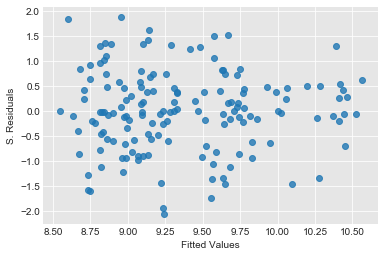

In [11]:
s_residuals = pd.Series(results.resid_pearson, name="S. Residuals")
fitted_values = pd.Series(results.fittedvalues, name="Fitted Values")
sns.regplot(fitted_values, s_residuals,  fit_reg=False)
plt.show()

In [12]:
res = pd.DataFrame(s_residuals)
drop_res = res[abs(res['S. Residuals'])>3].index.values
X_train.reset_index(inplace=True)
X_train.drop('index',axis=1,inplace=True)
y_train.reset_index(inplace=True, drop=True)
X_train.drop(drop_res,inplace=True)
y_train.drop(drop_res,inplace=True)

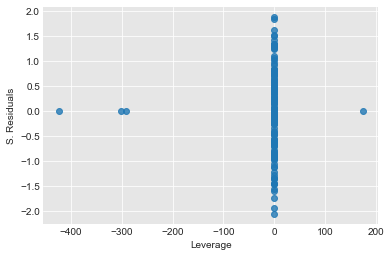

In [13]:
s_residuals = pd.Series(results.resid_pearson, name="S. Residuals")
leverage = pd.Series(OLSInfluence(results).influence, name = "Leverage")
sns.regplot(leverage, s_residuals,  fit_reg=False)
plt.show()

In [14]:
l = pd.DataFrame(leverage)
drop_l = l[abs(l['Leverage'])>((X_train.shape[1]+1)/X_train.shape[0])].index.values
X_train.reset_index(inplace=True)
X_train.drop('index',axis=1,inplace=True)
y_train.reset_index(inplace=True, drop=True)
X_train.drop(drop_l,inplace=True)
y_train.drop(drop_l,inplace=True)

In [15]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["features"] = X_train.columns
vif

,VIF Factor,features
0,3.942460e+00,normalized_losses
1,4.540019e+00,num_of_doors
2,2.202205e+01,wheel_base
3,4.444000e+01,curb_weight
4,2.608757e+01,num_of_cylinders
5,8.055368e+01,engine_size
6,1.109079e+01,bore
7,4.681885e+00,stroke
8,6.979981e+01,compression_ratio
9,5.729116e+01,horsepower


In [16]:
c = True
while c :
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif["features"] = X_train.columns
    v = vif[vif.index==vif['VIF Factor'].idxmax()]['VIF Factor'].values[0]
    if v > 10 :
        X_train.drop(vif[vif.index==vif['VIF Factor'].idxmax()]['features'].values,inplace=True,axis=1)
    else :
        c = False

In [17]:
vif

,VIF Factor,features
0,3.391287,symboling_1
1,2.808567,symboling_2
2,3.164829,symboling_3
3,3.156704,symboling__1
4,1.715611,symboling__2
5,1.432494,make_audi
6,1.744762,make_bmw
7,1.253065,make_chevrolet
8,2.025114,make_dodge
9,1.193507,make_honda


In [18]:
X_train.drop(labels=['make_isuzu','make_mercury','fuel_system_mfi','fuel_system_spfi'],inplace=True,axis=1)

In [19]:
model = sm.OLS(y_train,sm.add_constant(X_train))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Car_price   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     49.02
Date:                Mon, 12 Nov 2018   Prob (F-statistic):           2.02e-53
Time:                        01:18:52   Log-Likelihood:                 88.177
No. Observations:                 149   AIC:                            -110.4
Df Residuals:                     116   BIC:                            -11.22
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.2221 

In [20]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
        if not changed:
            break
    return included

In [21]:
result = stepwise_selection(X_train, y_train)

In [22]:
X_train = X_train[result]

In [23]:
model = sm.OLS(y_train,sm.add_constant(X_train))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              Car_price   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     103.0
Date:                Mon, 12 Nov 2018   Prob (F-statistic):           1.95e-65
Time:                        01:18:55   Log-Likelihood:                 77.682
No. Observations:                 149   AIC:                            -123.4
Df Residuals:                     133   BIC:                            -75.30
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.1528 

0.7950876528791331


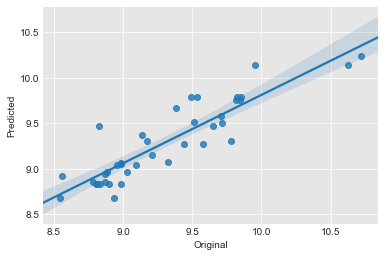

In [24]:
regression = LinearRegression()
regression.fit(X_train,y_train)
pred = regression.predict(X_test[X_train.columns])
Predictions = pd.DataFrame(np.array([y_test.values,pred]).T,columns=['Original','Predicted'])
print(regression.score(X_test[X_train.columns],y_test))
sns.regplot(x='Original',y='Predicted',data=Predictions)
plt.show()

In [25]:
master_columns = X_train.columns.values

In [26]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
def add_interactions(df) :
    combos = list(combinations(list(df.columns),2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    poly = PolynomialFeatures(interaction_only=True, include_bias= False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    return df

In [27]:
X_test = X_test[X_train.columns]

In [28]:
print(X_train.shape)
print(X_test.shape)

(149, 15)
(39, 15)


In [29]:
X_train1 = add_interactions(X_train)
noint_indices = [i for i,x in enumerate(list((X_train1==0).all())) if x]
X_train1 = X_train1.drop(X_train1.columns[noint_indices],axis=1)
X_test1 =  add_interactions(X_test)
X_test1 = X_test1[X_train1.columns]

In [30]:
print(X_train1.shape)
print(X_test1.shape)

(149, 54)
(39, 54)


In [31]:
model = sm.OLS(list(y_train),sm.add_constant(X_train1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     35.55
Date:                Mon, 12 Nov 2018   Prob (F-statistic):           1.11e-45
Time:                        01:18:56   Log-Likelihood:                 100.05
No. Observations:                 149   AIC:                            -106.1
Df Residuals:                     102   BIC:                             35.08
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

0.841588154437446


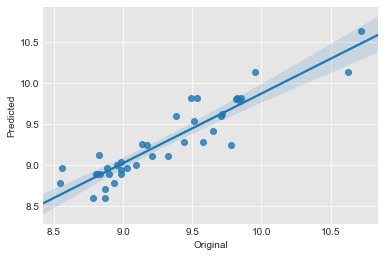

In [32]:
regression = LinearRegression()
regression.fit(X_train1,y_train)
pred = regression.predict(X_test1[X_train1.columns])
Predictions = pd.DataFrame(np.array([y_test.values,pred]).T,columns=['Original','Predicted'])
print(regression.score(X_test1[X_train1.columns],y_test))
sns.regplot(x='Original',y='Predicted',data=Predictions)
plt.show()

In [33]:
result1 = stepwise_selection(X_train1, list(y_train))

In [34]:
for i in master_columns :
    if i not in (result1) :
        result1.append(i)

In [35]:
X_train1 = X_train1[result1]

In [36]:
model = sm.OLS(list(y_train),sm.add_constant(X_train1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     95.08
Date:                Mon, 12 Nov 2018   Prob (F-statistic):           5.42e-65
Time:                        01:19:03   Log-Likelihood:                 81.832
No. Observations:                 149   AIC:                            -127.7
Df Residuals:                     131   BIC:                            -73.59
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

0.8243714241461231


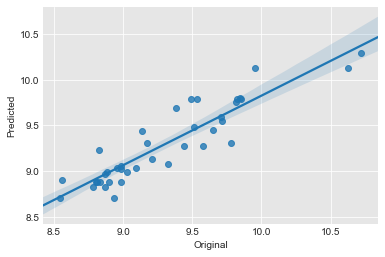

In [37]:
regression = LinearRegression()
regression.fit(X_train1,y_train)
pred = regression.predict(X_test1[X_train1.columns])
Predictions = pd.DataFrame(np.array([y_test.values,pred]).T,columns=['Original','Predicted'])
print(regression.score(X_test1[X_train1.columns],y_test))
sns.regplot(x='Original',y='Predicted',data=Predictions)
plt.show()

Optimal number of features : 21


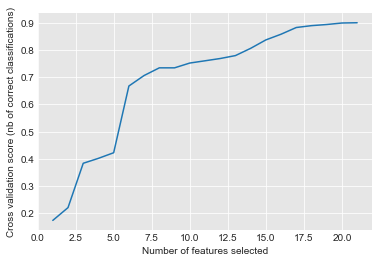

In [38]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
regression = LinearRegression()
rfecv = RFECV(estimator=regression, step=1, cv=kf)
rfecv.fit(X_train1, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()